<a href="https://colab.research.google.com/github/mxxsxx08/FinalPreprocessing/blob/main/Modeling_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import

In [13]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
import kagglehub
path = kagglehub.dataset_download("asjad99/mimiciii")
print(path)

/kaggle/input/mimiciii


In [14]:
df_PATIENTS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/PATIENTS.csv')
df_CHARTEVENTS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv')
df_ADMISSIONS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/ADMISSIONS.csv')
df_D_ITEMS = pd.read_csv('/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/D_ITEMS.csv')

df_ADMISSIONS = df_ADMISSIONS[df_ADMISSIONS['subject_id'] != 10120]
df_PATIENTS = df_PATIENTS[df_PATIENTS['subject_id'] != 10120]

df_PATIENTS = df_PATIENTS.loc[:,['subject_id','gender']]

# 2. 전처리


In [15]:
df_CHARTEVENTS['value'] = pd.to_numeric(df_CHARTEVENTS['value'], errors='coerce')
df_pivot = df_CHARTEVENTS[df_CHARTEVENTS['itemid'].isin([211, 618, 646])].loc[:,['subject_id','itemid','value','charttime']]\
.pivot_table(
    index=['subject_id', 'charttime'],
    columns='itemid',
    values='value'
).reset_index()
df_pivot = df_pivot.sort_values(by=['subject_id', 'charttime'])
df_pivot = df_pivot.rename(columns={211: 'Heart_Rate', 618: 'Resp_Rate', 646: 'SpO2'})

# NAN 채우기
# 각 subject_id별 평균 구하기
subject_means = df_pivot.groupby("subject_id")[["Heart_Rate", "Resp_Rate", "SpO2"]].transform("mean")

# NaN 값을 각 subject의 평균으로 채우기
df_pivot_filled = df_pivot.copy()
df_pivot_filled[["Heart_Rate", "Resp_Rate", "SpO2"]] = df_pivot[["Heart_Rate", "Resp_Rate", "SpO2"]].fillna(subject_means)

# datetime 형식으로 변환
df_pivot_filled['charttime'] = pd.to_datetime(df_pivot_filled['charttime'])

df_ADMISSIONS_flag = df_ADMISSIONS.loc[:,['subject_id','hospital_expire_flag']]

# 조인
df_merged = pd.merge(df_pivot_filled, df_ADMISSIONS_flag, on='subject_id', how='left')

In [16]:
df_ADMISSIONS_select = df_ADMISSIONS.loc[:,['subject_id','admission_type','admission_location','discharge_location',
                     'insurance','marital_status','ethnicity','diagnosis','hospital_expire_flag']]

df_ADMISSIONS_select_s = pd.merge(df_PATIENTS, df_ADMISSIONS_select, on='subject_id', how='left').drop(['hospital_expire_flag'],axis=1)
df_mgd = pd.merge(df_merged, df_ADMISSIONS_select_s, on='subject_id', how='left')


# 3. 모델 구현


## **LightGBM**
- 한 번 진단할 때마다 놓친 오류에 집중하며 새로운 작은 트리를 추가하여 오진을 줄여가는 방식
- 장점: 대용량에서도 학습 가능, 빠른 예측 속도, 결측치 자동 처리, 범주형 변수 핸들링 등
- 단점: 하이퍼파라미터가 많아 처음엔 기본값에서 튜닝까지의 신중한 접근이 필요하다.

In [22]:
# --- Feature / Label 지정
# 모델에 쓸 열들
numeric_features = ["Heart_Rate", "Resp_Rate", "SpO2"]
categorical_features = ["gender", "admission_type", "insurance", "marital_status", "ethnicity"]
all_features = numeric_features + categorical_features

X = df_mgd[all_features]
y = df_mgd["hospital_expire_flag"]

# --- 범주형 변수 처리
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# --- 모델 학습
cv = KFold(n_splits=5, shuffle=True, random_state=42)

lgbm = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

auc_scores = cross_val_score(lgbm, X_encoded, y, cv=cv, scoring="roc_auc")
print(f"[LightGBM] 5-fold ROC-AUC: {auc_scores.mean():.3f} ± {auc_scores.std():.3f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4418, number of negative: 6624
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 11042, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400109 -> initscore=-0.405012
[LightGBM] [Info] Start training from score -0.405012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4488, number of negative: 6554
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the over

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5563, number of negative: 8240
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 13803, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.403028 -> initscore=-0.392863
[LightGBM] [Info] Start training from score -0.392863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


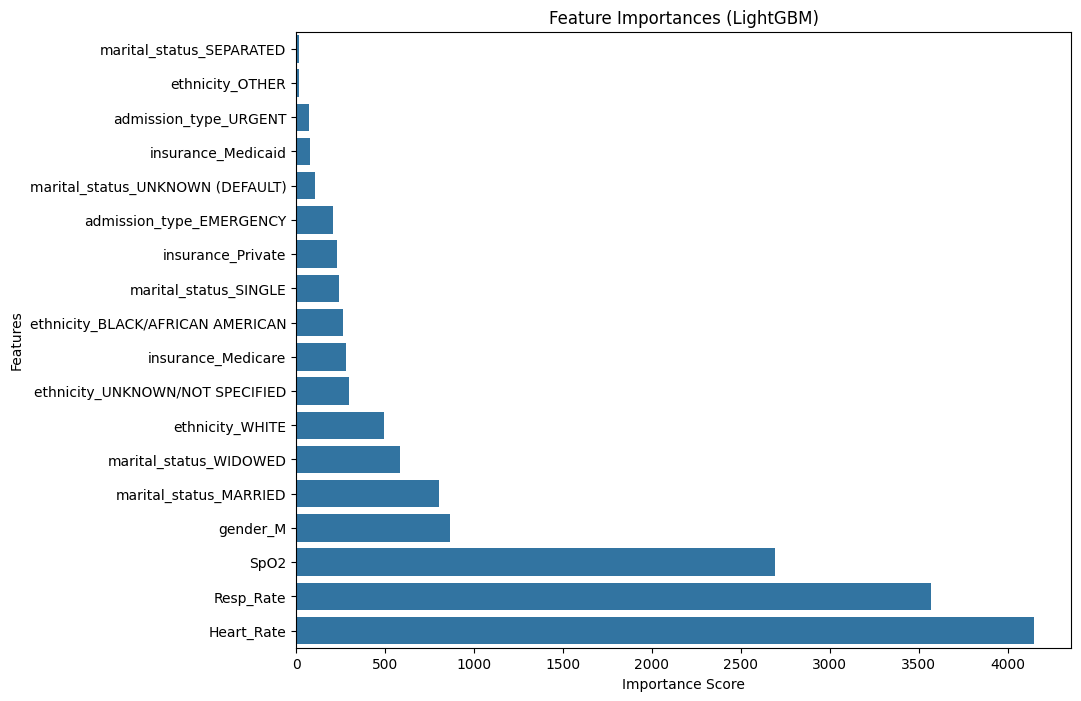

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 학습
lgbm.fit(X_encoded, y)

# 변수 중요도 가져오기
importances = pd.Series(lgbm.feature_importances_, index=X_encoded.columns)
importances = importances.sort_values(ascending=True)

# 그래프 그리기
plt.figure(figsize=(10, 8))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importances (LightGBM)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

**막대그래프: 어떤 변수가 예측에 얼마나 기여했는가**

Heart_Rate, Resp_Rate, SpO2, insurance 순으로 사망 예측의 중요도가 컸다.

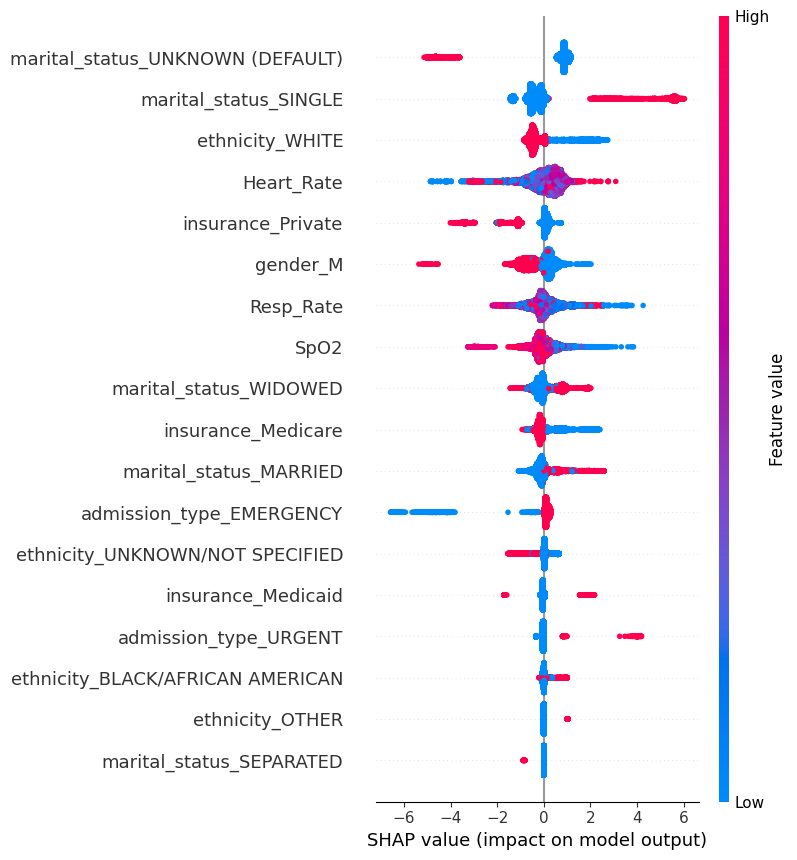

In [28]:
import shap

# SHAP 값 계산
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_encoded)

# Summary plot (전체 데이터)
shap.summary_plot(shap_values, X_encoded)

**SHAP 값 Summary Plot:** 개별 변수의 양·음 영향을 표시했다.

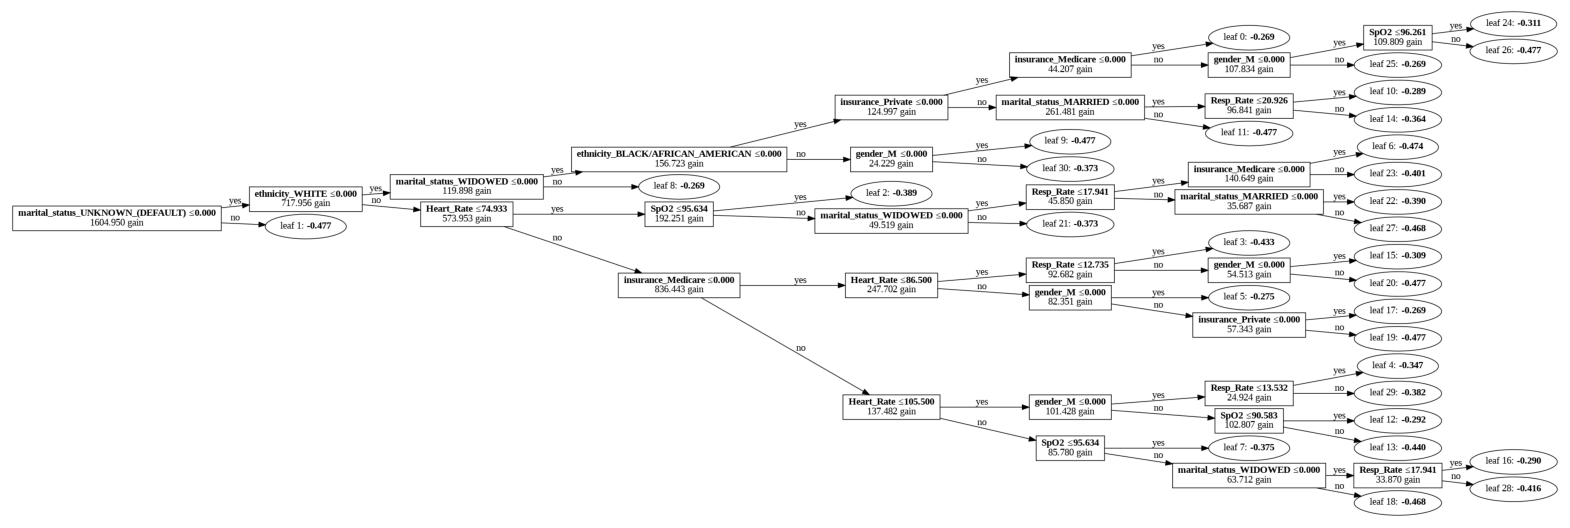

In [29]:
ax = lgb.plot_tree(lgbm, tree_index=0, figsize=(20, 10), show_info=['split_gain'])

- 사각형 노드: 각 분기(split)의 조건

  예: Heart_Rate ≤ 94.33

- 화살표 yes/no: 조건 만족 여부

- 타원형 leaf: 리프 노드(최종 예측값 위치)

- split_gain 값: 해당 분기에서 얻은 정보 이득(얼마나 유용한 분기였는지)



**발표 의도**

**1. 모델의 작동 방식 설명:** 우리 모델은 의료 데이터의 변수들을 기준으로 여러 단계로 분기하며 사망 여부를 예측한다.

**2. 모델의 직관적 해석 제공**

**3. 모델의 신뢰도 강조:** 트리 구조는 사람의 의사결정 과정과 유사하기 때문에 의료진도 이해하기 쉽다.

In [ ]:
'''
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

class LSTM_XGBoost_Model:
    def __init__(self, lstm_input_dim=3, lstm_hidden_dim=64, random_state=42):
        self.lstm_input_dim = lstm_input_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.random_state = random_state
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.static_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        self.xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
        self.lstm_model = self._build_lstm().to(self.device)

    def _build_lstm(self):
        class LSTMFeatureExtractor(nn.Module):
            def __init__(self, input_dim, hidden_dim):
                super().__init__()
                self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

            def forward(self, x):
                _, (hn, _) = self.lstm(x)
                return hn.squeeze(0)  # (batch, hidden_dim)

        return LSTMFeatureExtractor(self.lstm_input_dim, self.lstm_hidden_dim)

    def _prepare_sequences(self, df, vitals):
        df_sorted = df.sort_values(by=['subject_id', 'charttime'])
        sequences = df_sorted.groupby('subject_id')[vitals].apply(lambda x: torch.tensor(x.values, dtype=torch.float32))
        padded_seqs = pad_sequence(sequences.tolist(), batch_first=True)
        return padded_seqs, sequences.index.tolist()  # tensor, subject_ids

    def _prepare_static_features(self, df, static_cols, subject_ids, fit=True):
        static_df = df.groupby('subject_id').last().loc[subject_ids]
        if fit:
            static_encoded = self.static_encoder.fit_transform(static_df[static_cols])
        else:
            static_encoded = self.static_encoder.transform(static_df[static_cols])
        return static_encoded, static_df['hospital_expire_flag'].astype(int).values

    def fit(self, df, vitals, static_cols, target_col='hospital_expire_flag', test_size=0.2):
        padded_seqs, subject_ids = self._prepare_sequences(df, vitals)
        X_static, y = self._prepare_static_features(df, static_cols, subject_ids, fit=True)

        self.lstm_model.eval()
        with torch.no_grad():
            lstm_features = self.lstm_model(padded_seqs.to(self.device)).cpu().numpy()
            if lstm_features.ndim == 1:
                lstm_features = lstm_features.reshape(1, -1)

        X_static = np.asarray(X_static)
        if X_static.ndim == 1:
            X_static = X_static.reshape(1, -1)

        X = np.concatenate([X_static, lstm_features], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=self.random_state)

        self.xgb_model.fit(X_train, y_train)
        y_pred = self.xgb_model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        print(f"✅ Train/Test AUC-ROC: {auc:.4f}")
        return auc

    def predict(self, df, vitals, static_cols):
        padded_seqs, subject_ids = self._prepare_sequences(df, vitals)
        X_static, _ = self._prepare_static_features(df, static_cols, subject_ids, fit=False)

        self.lstm_model.eval()
        with torch.no_grad():
            lstm_features = self.lstm_model(padded_seqs.to(self.device)).cpu().numpy()
            if lstm_features.ndim == 1:
                lstm_features = lstm_features.reshape(1, -1)

        X_static = np.asarray(X_static)
        if X_static.ndim == 1:
            X_static = X_static.reshape(1, -1)

        X = np.concatenate([X_static, lstm_features], axis=1)
        preds = self.xgb_model.predict_proba(X)[:, 1]
        return pd.DataFrame({'subject_id': subject_ids, 'pred_prob': preds})
'''

In [ ]:
'''
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

class LSTM_XGBoost_Model:
    def __init__(self, lstm_input_dim=3, lstm_hidden_dim=64, random_state=42):
        self.lstm_input_dim = lstm_input_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.random_state = random_state
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.static_encoder = OneHotEncoder(handle_unknown='ignore')
        self.xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state)
        self.lstm_model = self._build_lstm().to(self.device)

    def _build_lstm(self):
        class LSTMFeatureExtractor(nn.Module):
            def __init__(self, input_dim, hidden_dim):
                super().__init__()
                self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

            def forward(self, x):
                _, (hn, _) = self.lstm(x)
                return hn.squeeze(0)  # (batch, hidden_dim)

        return LSTMFeatureExtractor(self.lstm_input_dim, self.lstm_hidden_dim)

    def _prepare_sequences(self, df, vitals):
        df_sorted = df.sort_values(by=['subject_id', 'charttime'])
        sequences = df_sorted.groupby('subject_id')[vitals].apply(lambda x: torch.tensor(x.values, dtype=torch.float32))
        padded_seqs = pad_sequence(sequences.tolist(), batch_first=True)
        return padded_seqs, sequences.index.tolist()

    def _prepare_static_features(self, df, static_cols, subject_ids):
        static_df = df.groupby('subject_id').last().loc[subject_ids]
        static_encoded = self.static_encoder.fit_transform(static_df[static_cols])
        return static_encoded, static_df['hospital_expire_flag'].astype(int).values

    def fit(self, df, vitals, static_cols, target_col='hospital_expire_flag', test_size=0.2):
        # Step 1: 시계열 시퀀스 처리
        padded_seqs, subject_ids = self._prepare_sequences(df, vitals)

        # Step 2: 정적 변수 인코딩 + 정답
        X_static, y = self._prepare_static_features(df, static_cols, subject_ids, fit=True)

        # Step 3: LSTM feature 추출
        self.lstm_model.eval()
        with torch.no_grad():
            lstm_features = self.lstm_model(padded_seqs.to(self.device)).cpu().numpy()

        # Step 4: 차원 문제 방지 (안전하게 reshape)
        X_static = np.asarray(X_static)
        lstm_features = np.asarray(lstm_features)

        if X_static.ndim == 1:
            X_static = X_static.reshape(1, -1)
        if lstm_features.ndim == 1:
            lstm_features = lstm_features.reshape(1, -1)

        # Step 5: 두 feature 결합
        try:
            X = np.concatenate([X_static, lstm_features], axis=1)
        except Exception as e:
            print("❌ Concatenation Error")
            print("X_static shape:", X_static.shape)
            print("lstm_features shape:", lstm_features.shape)
            raise e

        # Step 6: 학습
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=self.random_state)

        self.xgb_model.fit(X_train, y_train)
        y_pred = self.xgb_model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        print(f"✅ Train/Test AUC-ROC: {auc:.4f}")
        return auc


    def predict(self, df, vitals, static_cols):
        padded_seqs, subject_ids = self._prepare_sequences(df, vitals)
        static_df = df.groupby('subject_id').last().loc[subject_ids]
        X_static = self.static_encoder.transform(static_df[static_cols])

        self.lstm_model.eval()
        with torch.no_grad():
            lstm_features = self.lstm_model(padded_seqs.to(self.device)).cpu().numpy()

        X = np.concatenate([X_static, lstm_features], axis=1)
        preds = self.xgb_model.predict_proba(X)[:, 1]
        return pd.DataFrame({'subject_id': subject_ids, 'pred_prob': preds})
'''

In [ ]:
'''
from sklearn.model_selection import train_test_split
vitals = ['Heart_Rate', 'Resp_Rate', 'SpO2']

static_cols = ['gender', 'admission_type', 'admission_location',
               'discharge_location', 'insurance', 'marital_status',
               'ethnicity', 'diagnosis']


subject_ids = df_mgd['subject_id'].unique()
train_ids, test_ids = train_test_split(
    subject_ids,
    test_size=0.2,
    stratify=df_mgd.groupby('subject_id')['hospital_expire_flag'].first(),
    random_state=42
)

df_train = df_mgd[df_mgd['subject_id'].isin(train_ids)].copy()
df_test = df_mgd[df_mgd['subject_id'].isin(test_ids)].copy()

# 모델 정의 및 학습
model = LSTM_XGBoost_Model()
model.fit(df_train, vitals=vitals, static_cols=static_cols)

# 예측
preds_df = model.predict(df_test, vitals=vitals, static_cols=static_cols)
'''